# Integrated Sentinel-1 InSAR Workflow (Manager Modules + ISCE2)

This pipeline implements a modular end-to-end Sentinel-1 DInSAR workflow by combining dedicated data managers with an automated ISCE2 TOPS processor. Each manager prepares a specific class of required inputs, and the ISCE processor converts their outputs into a fully configured and executable interferometric run.

The architecture is designed for reproducibility, automation, and safe fallback handling across data acquisition, auxiliary preparation, and core interferometric processing.

---

## Workflow Structure

```

ROI
├── SLC Manager      → scene search, filtering, download
├── Orbit Manager    → precise/restituted orbit retrieval
├── DEM Manager      → DEM download, mosaic, ISCE formatting
└── ISCE Processor   → config generation + topsApp execution
↓
InSAR Products (wrapped, coherence, unwrapped, geocoded)

```

---

## SLC Manager

Handles Sentinel-1 SLC discovery and selection.

Functions:

- Search scenes by ROI and date range
- Filter incompatible acquisitions (track/path/burst overlap)
- Select master and secondary scenes
- Download SAFE archives
- Provide scene status and metadata to downstream modules

Outputs:

- Selected SLC SAFE files
- Master/secondary pairing
- Scene geometry and metadata

---

## Orbit Manager

Retrieves auxiliary orbit products required for accurate geometry.

Functions:

- Query orbit files for each selected scene
- Prefer **precise orbits (POEORB)**
- Automatically fallback to **restituted orbits (RESORB)** if needed
- Organize orbit files in processing directory
- Return orbit status to the processor

Purpose:

- Accurate baseline estimation
- Correct imaging geometry
- Stable co-registration

---

## DEM Manager

Prepares elevation data for topographic phase modeling.

Functions:

- Derive bounds from SLC intersection or ROI
- Apply configurable spatial buffer
- Download DEM tiles (e.g., Copernicus GLO-30)
- Mosaic and crop DEM
- Convert to ISCE DEM format
- Cache outputs for reuse

Purpose:

- Remove topographic phase
- Support flattening and geocoding
- Ensure full coverage of processing extent

---

## ISCE Processor

Builds and executes the ISCE2 TOPS InSAR workflow.

Functions:

- Initialize processing workspace
- Patch runtime environment if required
- Generate `topsApp.xml` automatically from manager status
- Inject:
  - SLC SAFE paths
  - Orbit directories
  - DEM path
  - ROI or bounding box
  - Swath selection
  - Multilooking parameters
  - Phase unwrapper choice (SNAPHU / ICU / etc.)
- Launch processing via topsApp

Processing stages include:

1. Burst extraction and preprocessing  
2. Co-registration  
3. Interferogram formation  
4. Topographic phase removal  
5. Filtering  
6. Phase unwrapping  
7. Geocoding  

Outputs:

- Filtered interferogram
- Coherence maps
- Unwrapped phase
- LOS geometry layers
- Geocoded rasters

---

## Design Goals

- Modular responsibility separation
- Automatic configuration generation
- Reproducible processing runs
- Safe fallback for missing auxiliary data
- ROI-aware but coverage-safe DEM logic
- Suitable for both quick tests and scientific runs

---

## Typical Usage Pattern

1. Define ROI and time range  
2. Run managers to prepare SLC, orbit, and DEM  
3. Generate ISCE configuration automatically  
4. Execute processing  
5. Perform reference correction and displacement analysis in post-processing

## 0. Pre-Setup

In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))

# get current working dir
%pwd

'/raven/u/yhsuh/coding/INSAR/examples'

🚀 Starting InSAR Full Pipeline Integration Test...
📂 Work Base: /raven/u/yhsuh/coding/INSAR/examples/test_pipeline_output

🔵 [Step 1] SLC Manager: Setup & Select
[Search] API Search Sentinel-1 SLC (2025-10-01 ~ 2026-01-10) | ALL...
[Search] Found 17 scenes.
   Found 17 scenes.
[Master] Set to Idx 0. Filtered 8 incompatible scenes (Path 134).
[Select] Added Index 0
[Select] Added Index 2
[Auth] Initializing NASA Earthdata Authentication...
 [Auth] Logged in successfully.

[Download] Starting Sequential Download (2 files) to raw_data...
[1/2] Found existing file: S1C_IW_SLC__1SDV_20260102T213001_20260102T213028_005730_00B73A_280A.zip
[2/2] Found existing file: S1C_IW_SLC__1SDV_20251221T213001_20251221T213028_005555_00B135_DA0F.zip
✅ SLC Ready.

🔵 [Step 2] Orbit Manager: Fetching
[Auth] Initializing NASA Earthdata Authentication...
 [Auth] Logged in successfully.

[OrbitManager] Checking orbits for 2 scenes...
               Target Dir: test_pipeline_output/orbits
               Mode: Aut

/u/yhsuh/conda-envs/insar_env/lib/python3.10/site-packages/osgeo/gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(
2026-02-03 01:08:44,968 - ISCEProcessor - INFO - 🔧 Checking and patching environment for ISCE2...
2026-02-03 01:08:44,969 - ISCEProcessor - INFO -    -> Added /u/yhsuh/conda-envs/insar_env/bin to PATH


   ✅ Export complete.
✅ DEM Ready: test_pipeline_output/dem/dem.wgs84

🔵 [Step 4] ISCE Processor: Configuration & Patching
Using default ISCE Path: /u/yhsuh/conda-envs/insar_env/lib/python3.10/site-packages/isce
✅ XML Config created at: /raven/u/yhsuh/coding/INSAR/examples/test_pipeline_output/isce_run_01/topsApp.xml

🔵 [Step 5] Final Map Check



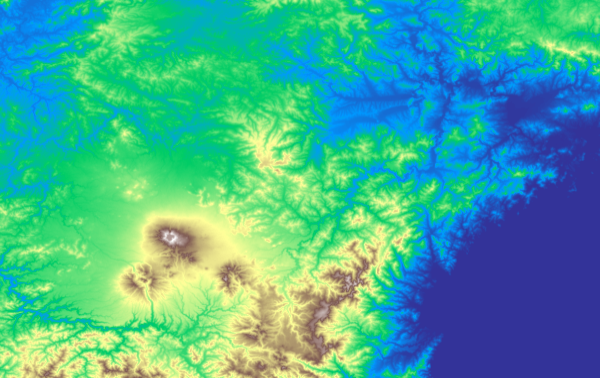

In [2]:
import os
import shutil
import pandas as pd
import folium
from pathlib import Path
from shapely.geometry import shape

# --- Custom Modules ---
from modules.SLC_manager import S1SLCManager
from modules.orbit_manager import OrbitManager 
from modules.DEM_manager import DEMManager
from modules.isce_processor import ISCEProcessor

# ==============================================================================
# 0. Global Configuration (환경 설정)
# ==============================================================================
BASE_DIR = Path("test_pipeline_output")

# [주의] 테스트를 위해 기존 폴더를 초기화하려면 아래 주석을 해제하세요.
# if BASE_DIR.exists(): shutil.rmtree(BASE_DIR) 
BASE_DIR.mkdir(exist_ok=True)

RAW_DIR = "raw_data"            # SLC 원본 저장소
ORBIT_DIR = BASE_DIR / "orbits"
DEM_DIR = BASE_DIR / "dem"
PROCESS_DIR = BASE_DIR / "isce_run_01"

# ROI: 북한-중국 접경 지역 (작은 단위 테스트용)
ROI = "POLYGON((129.2 42.2, 129.3 42.2, 129.3 42.3, 129.2 42.3, 129.2 42.2))"

print("🚀 Starting InSAR Full Pipeline Integration Test...")
print(f"📂 Work Base: {BASE_DIR.resolve()}\n")


# ==============================================================================
# 1. SLC Manager: Search & Selection
# ==============================================================================
print("🔵 [Step 1] SLC Manager: Setup & Select")
slc_man = S1SLCManager(roi_wkt=ROI, data_dir=RAW_DIR)

# 검색 (로컬 파일 활용을 위해 날짜 범위 지정)
df = slc_man.search_images("2025-10-01", "2026-01-10")
print(f"   Found {len(df)} scenes.")

if len(df) > 0:
    # Master(0번)와 Slave(1번 또는 2번) 자동 선택
    master_idx = 0
    slc_man.set_master(master_idx)
    slave_idx = 2 if len(df) > 2 else 1
    slc_man.add_selected([master_idx, slave_idx])

    slc_man.download_selected()
    print("✅ SLC Ready.")
else:
    raise ValueError("❌ 검색된 SLC가 없습니다. 날짜나 ROI를 확인하세요.")


# ==============================================================================
# 2. Orbit Manager: Fetch Precise Orbits
# ==============================================================================
print("\n🔵 [Step 2] Orbit Manager: Fetching")
try:
    orbit_man = OrbitManager(orbit_dir=ORBIT_DIR)
    
    # 다운로드된 파일 기반으로 궤도 파일 검색
    target_files = slc_man.downloaded_files if slc_man.downloaded_files else slc_man.search_df['Scene ID'].tolist()
    orbit_man.fetch_orbits(target_files, precise_only=False) 
    print("✅ Orbit Ready.")

except Exception as e:
    print(f"❌ Orbit Error: {e}")
    # 에러 발생 시 더미 객체 생성 (테스트 진행용)
    class DummyOrbit:
        def get_status(self): return {'orbit_dir': str(ORBIT_DIR), 'aux_dir': str(ORBIT_DIR)}
    orbit_man = DummyOrbit()


# ==============================================================================
# 3. DEM Manager: Prepare DEM
# ==============================================================================
print("\n🔵 [Step 3] DEM Manager: Processing")
dem_man = DEMManager(save_dir=DEM_DIR#, 
                    # temp_dir=BASE_DIR/"dem_temp" # specify tempdir if needed
                    )

# ROI 정보를 넘겨주지만, DEMManager 내부 로직에 따라 SLC 전체 영역을 커버할 수 있음 (안전함)
dem_path = dem_man.prepare_dem(
    slc_manager=slc_man, # has priority over roi_wkt
    dem_name='glo_30',
    buffer_deg=0.2,
    #roi_wkt=ROI, 
    overwrite=True
)

if dem_path:
    print(f"✅ DEM Ready: {dem_path}")
else:
    raise RuntimeError("❌ DEM Preparation Failed.")


# ==============================================================================
# 4. ISCE Processor: Generate Config
# ==============================================================================
print("\n🔵 [Step 4] ISCE Processor: Configuration & Patching")

# 1. 프로세서 초기화 (자동 환경 패치 수행)
processor = ISCEProcessor(
    work_dir=PROCESS_DIR,
    raw_data_dir=RAW_DIR,
    dem_path=dem_path
)

st_slc = slc_man.get_status()
st_orb = orbit_man.get_status()
st_dem = dem_man.get_status()

# 2. topsApp.xml 생성
processor.create_config(
    slc_status=st_slc,
    orbit_status=st_orb,
    dem_status=st_dem,
    #roi_wkt=ROI,        # ROI 입력 (ISCE가 이 영역만 처리하도록 함)
    #slc_bbox=None,      # ROI가 있으므로 BBox는 필요 없음
    unwrapper="snaphu"
)

# 설정 파일 생성 확인
if processor.xml_path.exists():
    print(f"✅ XML Config created at: {processor.xml_path}")
else:
    print("❌ XML Config creation failed.")


# ==============================================================================
# 5. Final Visualization
# ==============================================================================
print("\n🔵 [Step 5] Final Map Check")

# [수정 포인트] 인자 이름을 roi_wkt로 정확히 지정
m = dem_man.plot_dem(max_pixels=600, roi_wkt=ROI)

if m:
    # SLC 프레임 표시 (Master: Green, Slave: Orange)
    folium.GeoJson(slc_man.results[master_idx].geojson(), 
                   style_function=lambda x: {'color': 'green', 'dashArray': '5,5', 'fill': False}, 
                   name="Master Frame").add_to(m)

m

In [3]:
# ==============================================================================
# 7. Run Processing
# ==============================================================================
print("\n🔵 [Step 7] Execution Test (Optional)")
print("To run the pipeline, uncomment the line below.")

# 실제 실행 테스트 (가장 중요한 부분)
# processor.run_process(start_step="startup", end_step="preprocess") # 일단 preprocess까지만 테스트
processor.run_process()

print("\n🎉 Test Script Setup Completed!")


🔵 [Step 7] Execution Test (Optional)
To run the pipeline, uncomment the line below.
  | 2026-02-03 01:09:16,081 - isce.insar - INFO - ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION =
  | ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION =
  | 
  | 2026-02-03 01:09:16,212 - isce.insar - WARNING - Some filenames in insarApp.geocode_list configuration are different from those in InsarProc. Using names given to insarApp.
  | /u/yhsuh/conda-envs/insar_env/lib/python3.10/site-packages/osgeo/gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  | warnings.warn(
  | insarApp.geocode_list = ['merged/phsig.cor', 'merged/filt_topophase.unw', 'merged/los.rdr', 'merged/topophase.flat', 'merged/filt_topophase.flat', 'merged/topophase.cor', 'merged/z.rdr', 'merged/lat.rdr', 'merged/lon.rdr']
  | InsarP


🔵 [Step 8] Result Verification & Data Loading Test
⚠️ Note: This step works best AFTER running Step 7 (Execution).

📋 1. Checking Output Directory (merged/)...
   ✅ Found 6 geocoded files.


,Filename,Type,Size (MB),Path
0,filt_topophase.flat.geo,Geocoded,682.49,/raven/u/yhsuh/coding/INSAR/examples/test_pipe...
1,filt_topophase.unw.geo,Geocoded,682.49,/raven/u/yhsuh/coding/INSAR/examples/test_pipe...
2,los.rdr.geo,Geocoded,682.49,/raven/u/yhsuh/coding/INSAR/examples/test_pipe...
3,phsig.cor.geo,Geocoded,341.24,/raven/u/yhsuh/coding/INSAR/examples/test_pipe...
4,topophase.cor.geo,Geocoded,682.49,/raven/u/yhsuh/coding/INSAR/examples/test_pipe...
5,topophase.flat.geo,Geocoded,682.49,/raven/u/yhsuh/coding/INSAR/examples/test_pipe...



📂 2. Loading Raster Test: [filt_topophase.unw.geo]
   ✅ Successfully Loaded!
   - Driver: VRT
   - Size: 12626 x 7085 pixels
   - Bands: 2
   - CRS: EPSG:4326
   - Bounds: BoundingBox(left=127.102611214, bottom=41.351676052, right=130.609836242, top=43.319733182)
   - Stats (Min/Max): 0.3661 / 6461300.5000
   ✅ Successfully Loaded!
   - Driver: VRT
   - Size: 12626 x 7085 pixels
   - Bands: 2
   - CRS: EPSG:4326
   - Bounds: BoundingBox(left=127.102611214, bottom=41.351676052, right=130.609836242, top=43.319733182)
   - Stats (Min/Max): -99.9839 / -58.8531

🖼️ Generating Preview for ROI area...


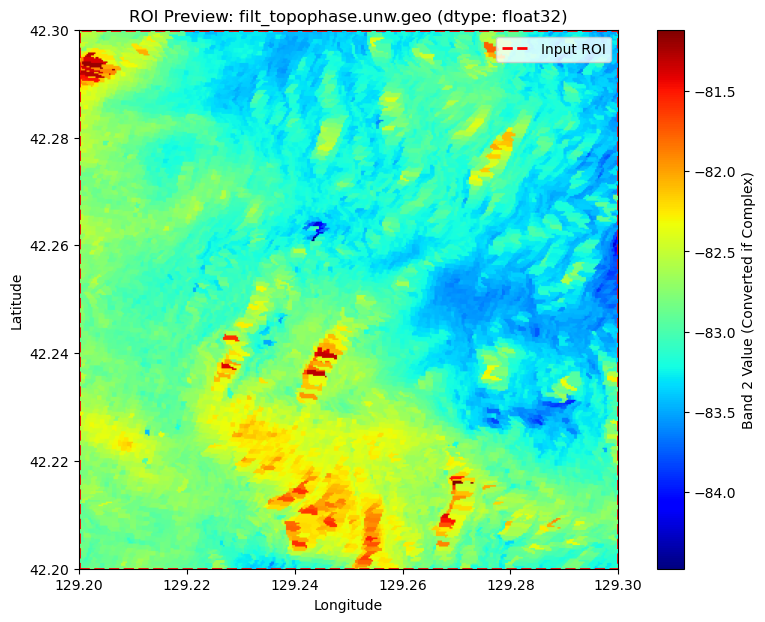


🎉 All Tests Completed!


In [4]:
# ==============================================================================
# 8. Post-Processing: Result Check & Data Loading (New!)
# ==============================================================================
print("\n🔵 [Step 8] Result Verification & Data Loading Test")
print("⚠️ Note: This step works best AFTER running Step 7 (Execution).")

# 1. 결과 파일 목록 조회 (get_results 테스트)
print("\n📋 1. Checking Output Directory (merged/)...")
# geocoded_only=True: .geo 파일만 필터링 / False: 모든 단계 파일 확인
df_results = processor.get_results(geocoded_only=True) 

if not df_results.empty:
    print(f"   ✅ Found {len(df_results)} geocoded files.")
    display(df_results)
    
    # 2. 데이터 로드 테스트 (load_raster 테스트)
    # 목록에 있는 첫 번째 파일을 실제로 로드해봅니다.
    target_filename = df_results.iloc[1]['Filename']
    print(f"\n📂 2. Loading Raster Test: [{target_filename}]")
    
    try:
        # load_raster 메서드로 파일 열기
        with processor.load_raster(target_filename) as src:
            print(f"   ✅ Successfully Loaded!")
            print(f"   - Driver: {src.driver}")
            print(f"   - Size: {src.width} x {src.height} pixels")
            print(f"   - Bands: {src.count}")
            print(f"   - CRS: {src.crs}")
            print(f"   - Bounds: {src.bounds}")
            
            # (선택) 밴드 데이터 통계 살짝 확인
            data = src.read(1)
            import numpy as np
            # 0이나 NaN 제외하고 통계 출력
            valid_data = data[(data != 0) & (~np.isnan(data))]
            if valid_data.size > 0:
                print(f"   - Stats (Min/Max): {valid_data.min():.4f} / {valid_data.max():.4f}")
            else:
                print(f"   - Stats: No valid data found (yet).")


        with processor.load_raster(target_filename) as src:
            print(f"   ✅ Successfully Loaded!")
            print(f"   - Driver: {src.driver}")
            print(f"   - Size: {src.width} x {src.height} pixels")
            print(f"   - Bands: {src.count}")
            print(f"   - CRS: {src.crs}")
            print(f"   - Bounds: {src.bounds}")
            b_idx = 2 if src.count >= 2 else 1
            data = src.read(b_idx)
            
            import numpy as np
            import matplotlib.pyplot as plt
            from rasterio.windows import from_bounds
            from shapely.wkt import loads as load_wkt

            # 0이나 NaN 제외하고 통계 출력
            valid_data = data[(data != 0) & (~np.isnan(data))]
            if valid_data.size > 0:
                print(f"   - Stats (Min/Max): {valid_data.min():.4f} / {valid_data.max():.4f}")
            else:
                print(f"   - Stats: No valid data found (yet).")

            # ==========================================================
            # [NEW] ROI 기반 시각화 추가 (Except 문 바로 앞)
            # ==========================================================
            print(f"\n🖼️ Generating Preview for ROI area...")
            roi_geom = load_wkt(ROI)
            minx, miny, maxx, maxy = roi_geom.bounds
            
            # ROI 영역만 효율적으로 읽기 위한 Window 설정
            win = from_bounds(minx, miny, maxx, maxy, transform=src.transform)
            roi_data = src.read(b_idx, window=win)

            # [핵심] 복소수 데이터 타입인지 확인하여 변환
            if np.iscomplexobj(roi_data):
                print("   ℹ️ Complex data detected. Converting to Phase (Angle)...")
                # 1. 위상(Phase)을 보고 싶다면: np.angle(roi_data)
                # 2. 진폭(Amplitude)을 보고 싶다면: np.abs(roi_data)
                roi_data = np.angle(roi_data) 
            
            roi_data = np.where(roi_data == 0, np.nan, roi_data) # 0값 마스킹
            
            fig, ax = plt.subplots(figsize=(10, 7))
            
            # 실제 지리 좌표(extent) 설정하여 도시
            ext = [minx, maxx, miny, maxy]
            im = ax.imshow(roi_data, extent=ext, cmap='jet', origin='upper')
            plt.colorbar(im, ax=ax, label=f'Band {b_idx} Value (Converted if Complex)')
            
            # ROI 경계선 오버레이
            rx, ry = roi_geom.exterior.xy
            ax.plot(rx, ry, color='red', linestyle='--', linewidth=2, label='Input ROI')
            
            ax.set_title(f"ROI Preview: {target_filename} (dtype: {src.dtypes[b_idx-1]})")
            ax.set_xlabel("Longitude")
            ax.set_ylabel("Latitude")
            ax.legend()
            plt.show()
    except Exception as e:
        print(f"   ❌ Failed to load raster: {e}")

else:
    print("   ❌ No geocoded results found yet.")
    print("      (Did you uncomment and run 'processor.run_process()' in Step 7?)")

print("\n🎉 All Tests Completed!")

📊 Calculating Statistics for ROI in: [filt_topophase.unw.geo]


,Metric,Phase (rad),Displacement (mm)
0,Mean (평균),-82.9469,366.1129
1,Median (중앙값),-82.9757,366.2399
2,Std Dev (표준편차),0.3620,1.5977
3,Min (최소),-84.4759,358.0446
4,Max (최대),-81.1190,372.8615
5,Range (범위),3.3569,14.8169


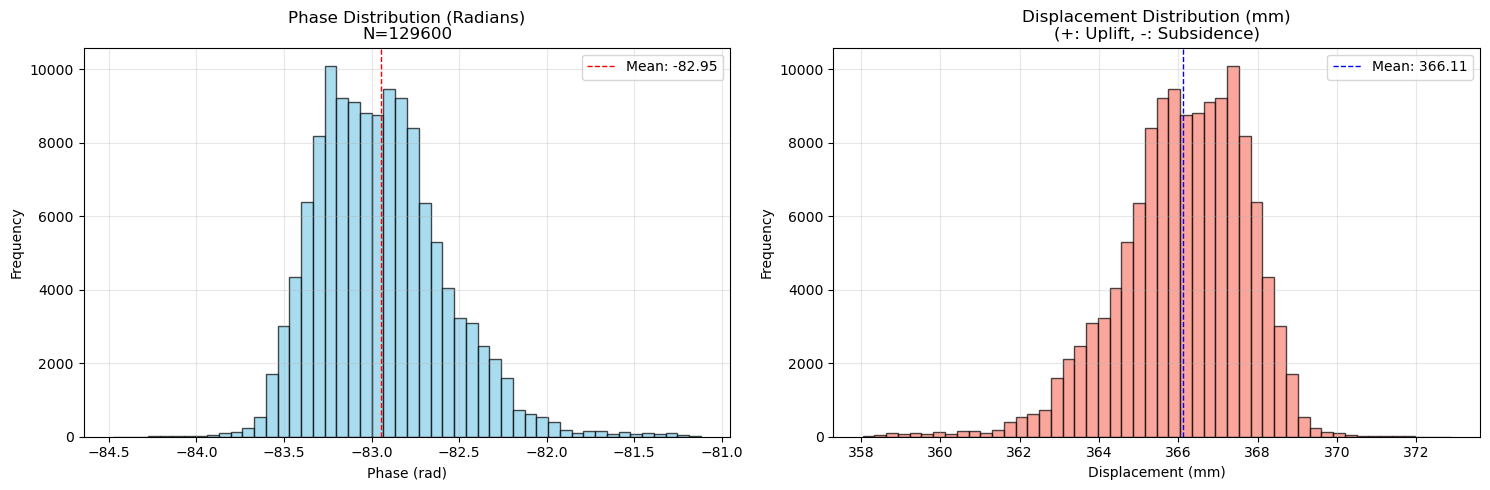

✅ Interpretation:
  - 평균 변위가 366.11 mm 입니다.
  - 표준편차가 1.60 mm로, 데이터가 안정적을 의미합니다.


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from shapely.wkt import loads as load_wkt
from rasterio.windows import from_bounds

# 1. 분석할 파일 지정 (Unwrapped Phase)
# (Step 8에서 찾은 파일명을 그대로 쓰거나, 직접 지정하세요)
target_filename = "filt_topophase.unw.geo" 

# Sentinel-1 파장 (미터 단위)
WAVELENGTH = 0.0554657 

print(f"📊 Calculating Statistics for ROI in: [{target_filename}]")

try:
    # 2. ROI 경계 좌표 추출
    roi_geom = load_wkt(ROI)
    minx, miny, maxx, maxy = roi_geom.bounds

    # 3. Rasterio를 사용하여 효율적으로 로딩
    with processor.load_raster(target_filename) as src:
        # ROI에 해당하는 윈도우(Pixel Window) 계산
        win = from_bounds(minx, miny, maxx, maxy, transform=src.transform)
        
        # 2번 밴드(Phase) 읽기 (Band 2 = Phase in ISCE unwrapped files)
        # 윈도우 크기만큼만 메모리에 올리므로 매우 빠름
        raw_data = src.read(2, window=win)
        
        # 4. 데이터 전처리
        # 0.0은 NoData로 취급하여 NaN으로 변경 (통계 왜곡 방지)
        data = np.where(raw_data == 0, np.nan, raw_data)
        
        # 유효한 데이터만 추출 (1차원 배열로 변환)
        valid_pixels = data[~np.isnan(data)]

        if valid_pixels.size == 0:
            print("❌ Error: ROI 영역 내에 유효한 데이터가 없습니다 (All NaNs).")
        else:
            # 5. 단위 변환 (Radians -> mm)
            # 변위 공식: d = -(lambda / 4pi) * phase
            # (mm 단위 변환을 위해 * 1000)
            disp_mm = -(WAVELENGTH / (4 * np.pi)) * valid_pixels * 1000

            # 6. 통계량 계산 및 출력
            stats = {
                "Metric": ["Mean (평균)", "Median (중앙값)", "Std Dev (표준편차)", "Min (최소)", "Max (최대)", "Range (범위)"],
                "Phase (rad)": [
                    np.mean(valid_pixels), np.median(valid_pixels), np.std(valid_pixels),
                    np.min(valid_pixels), np.max(valid_pixels), np.ptp(valid_pixels)
                ],
                "Displacement (mm)": [
                    np.mean(disp_mm), np.median(disp_mm), np.std(disp_mm),
                    np.min(disp_mm), np.max(disp_mm), np.ptp(disp_mm)
                ]
            }
            
            # DataFrame으로 깔끔하게 출력
            df_stats = pd.DataFrame(stats)
            pd.options.display.float_format = '{:.4f}'.format
            display(df_stats)

            # 7. 히스토그램 시각화 (분포 확인)
            fig, ax = plt.subplots(1, 2, figsize=(15, 5))

            # Phase Histogram
            ax[0].hist(valid_pixels, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
            ax[0].set_title(f"Phase Distribution (Radians)\nN={valid_pixels.size}")
            ax[0].set_xlabel("Phase (rad)")
            ax[0].set_ylabel("Frequency")
            ax[0].grid(True, alpha=0.3)
            # 평균선
            ax[0].axvline(np.mean(valid_pixels), color='red', linestyle='dashed', linewidth=1, label=f'Mean: {np.mean(valid_pixels):.2f}')
            ax[0].legend()

            # Displacement Histogram
            ax[1].hist(disp_mm, bins=50, color='salmon', edgecolor='black', alpha=0.7)
            ax[1].set_title(f"Displacement Distribution (mm)\n(+: Uplift, -: Subsidence)")
            ax[1].set_xlabel("Displacement (mm)")
            ax[1].set_ylabel("Frequency")
            ax[1].grid(True, alpha=0.3)
            # 평균선
            ax[1].axvline(np.mean(disp_mm), color='blue', linestyle='dashed', linewidth=1, label=f'Mean: {np.mean(disp_mm):.2f}')
            ax[1].legend()

            plt.tight_layout()
            plt.show()
            
            print("✅ Interpretation:")
            print(f"  - 평균 변위가 {np.mean(disp_mm):.2f} mm 입니다.")
            print(f"  - 표준편차가 {np.std(disp_mm):.2f} mm로, 데이터가 {'안정적' if np.std(disp_mm) < 5 else '노이즈가 심하거나 변동이 큼'}을 의미합니다.")

except Exception as e:
    print(f"❌ Error during statistics calculation: {e}")

In [7]:
import isce
import os
from pathlib import Path
import sys

# 1. ISCE 설치 위치 확인
isce_path = Path(os.path.dirname(isce.__file__))
print(f"📍 ISCE Location: {isce_path}")

# 2. 가능한 후보지들 검사
candidates = [
    Path(sys.prefix) / "bin" / "topsApp.py",                     # Conda 기본 bin
    isce_path / "applications" / "topsApp.py",                   # ISCE 내부 applications
    isce_path / "bin" / "topsApp.py",                            # ISCE 내부 bin
    Path("/usr/bin/topsApp.py")                                  # 시스템 기본
]

found = False
for path in candidates:
    if path.exists():
        print(f"✅ Found topsApp.py here: {path}")
        found = True
        break

if not found:
    print("❌ Still cannot find topsApp.py automatically.")
    print("   Try running this in terminal: find / -name topsApp.py 2>/dev/null")

📍 ISCE Location: /u/yhsuh/conda-envs/insar_env/lib/python3.10/site-packages/isce
✅ Found topsApp.py here: /u/yhsuh/conda-envs/insar_env/lib/python3.10/site-packages/isce/applications/topsApp.py
